In [73]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

sns.set_style('white', {'legend.frameon':True})
mpl.rcParams['figure.figsize'] = 25, 10

In [74]:
trenovacie = pd.read_csv("data/predspracovane_train.csv")

In [108]:
trenovacie = trenovacie.drop(['name', 'address'], axis=1)

In [75]:
trenovacie['class'].unique()

array(['negative', 'increased binding protein',
       'decreased binding protein'], dtype=object)

In [76]:
overovacie = pd.read_csv("data/predspracovane_valid.csv")
testovacie = pd.read_csv("data/predspracovane_test.csv")


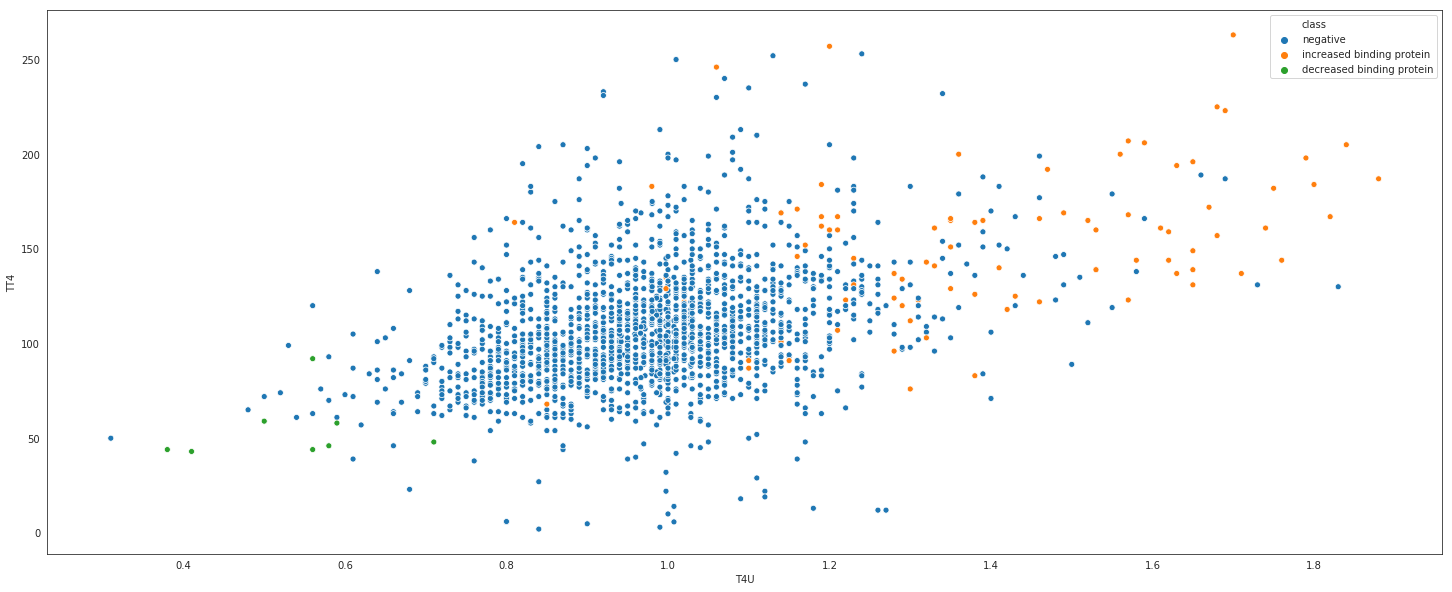

In [77]:
sns.scatterplot('T4U', 'TT4', data=trenovacie[['T4U', 'TT4', 'class']], hue='class')

Pre manualne pravidla rozhodovania sme zvolili atributy T4U a TT4. Podla scatterplotu vidno, ze maju vplyv na class. Increased binding protein bude ked je T4U viac ako 1.2 alebo TT4 viac ako 172. Decreased ak je T4U menej ako 0.7 alebo TT4 menej ako 50. V ostatnych pripadoch je negative.

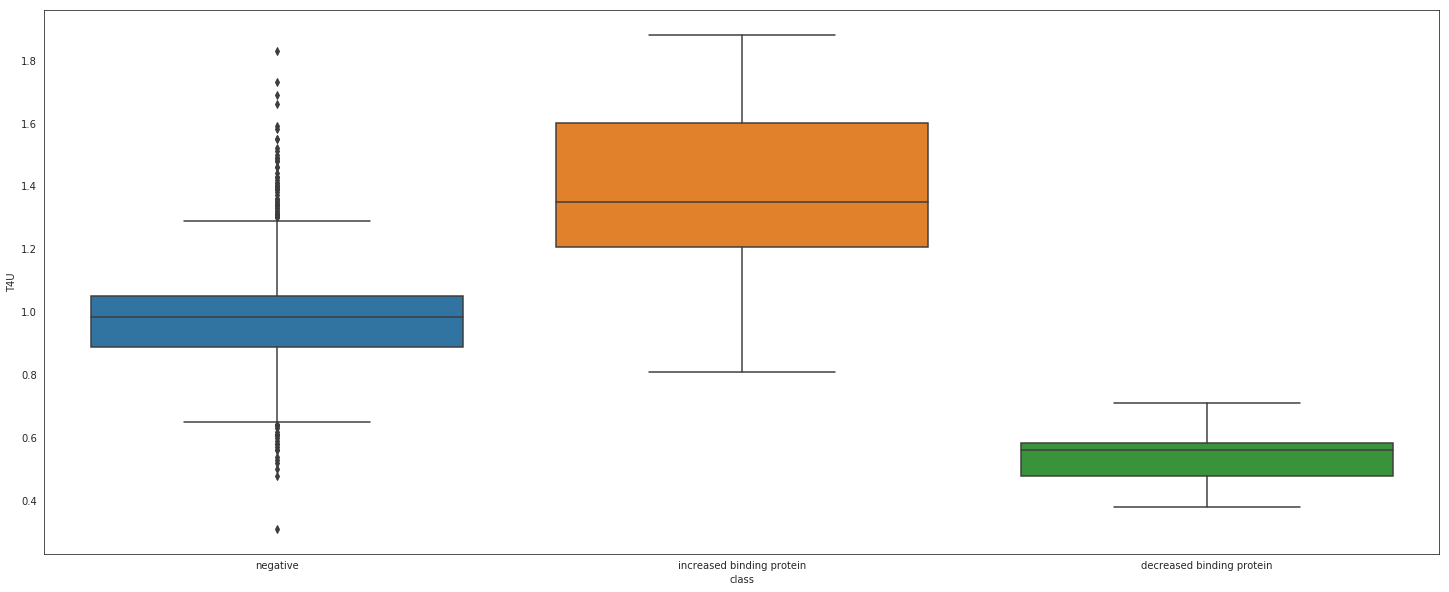

In [78]:
sns.boxplot('class', 'T4U', data=trenovacie)

Na pravidlo podla jedneho atributu sme zvolil T4U, lebo sa zda mat najmenej prekryvajucich sa hodnot. Hranica medzi Increased binding protein a negative je T4U=1,1, medzi Decreased binding protein a negative je T4U=0.7

In [79]:
porovnanie_vysledkov = pd.DataFrame({'Sposob': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1 macro': []})

In [80]:
def podla_testyriu(data):
    vysledok = []
    for zaznam in data['T4U']:
        if zaznam < 0.7:
            vysledok.append('decreased binding protein')
        elif zaznam > 1.1:
            vysledok.append('increased binding protein')
        else:
            vysledok.append('negative')
            
    return vysledok


manualna_jeden = podla_testyriu(overovacie)
# VYPIS METRIK PRE MANUALNE PRAVIDLA S JEDNYM ATRIBUTOM
a = accuracy_score(overovacie['class'], manualna_jeden)
p = precision_score(overovacie['class'], manualna_jeden, average='macro')
r = recall_score(overovacie['class'], manualna_jeden, average='macro')
f = f1_score(overovacie['class'], manualna_jeden, average='macro')
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Manualne pravidlo T4U', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)


Accuracy 	: 0.8065843621399177
Precision	: 0.428111620087498
Recall 	: 0.907515923566879


In [81]:
def podla_testyriuaajtetestyritamdajmenechjesranda(data):
    vysledok = []
    for testyriu, tetestyri in data[['T4U', 'TT4']].values:
        # 172, 1.2
        # print(zaznam)
        if testyriu > 1.2 or tetestyri > 172:
            vysledok.append('increased binding protein')
        elif testyriu < 0.7 or tetestyri < 50:
            vysledok.append('decreased binding protein')
        else:
            vysledok.append('negative')
            
    return vysledok


manualna_dva = podla_testyriuaajtetestyritamdajmenechjesranda(overovacie)
# VYPIS METRIK PRE MANUALNE PRAVIDLA S DVOMA ATRIBUTMI
a = accuracy_score(overovacie['class'], manualna_dva)
p = precision_score(overovacie['class'], manualna_dva, average='macro')
r = recall_score(overovacie['class'], manualna_dva, average='macro')
f = f1_score(overovacie['class'], manualna_dva, average='macro')
print('Accuracy \t: ' + str(a))
print('Precision\t: ' + str(p))
print('Recall \t: ' + str(r))
porovnanie_vysledkov = porovnanie_vysledkov.append({'Sposob': 'Manualne pravidlo T4U+TT4', 'accuracy': a, 'precision': p, 'recall': r, 'f1 macro': f}, ignore_index=True)

Accuracy 	: 0.8621399176954733
Precision	: 0.43110705233427565
Recall 	: 0.9006652512384997


In [104]:
stlpce_na_zakodovanie = ['FTI measured', 'education', 'lithium', 'on thyroxine', 'tumor', 'relationship',
                         'thyroid surgery', 'workclass', 'I131 treatment', 'marital-status', 'goitre',
                         'native-country', 'hypopituitary', 'query on thyroxine', 'T3 measured', 'referral source',
                         'occupation', 'TBG measured', 'race', 'pregnant', 'TSH measured', 'query hyperthyroid',
                         'TT4 measured', 'on antithyroid medication', 'sick', 'T4U measured', 'psych',
                         'query hypothyroid', 'sex']

def zakoduj(data):
    return pd.get_dummies(data, columns=stlpce_na_zakodovanie)  # ONE HOT ENCODING

zakodovane_trenovacie = zakoduj(trenovacie)


In [111]:
from sklearn.compose import ColumnTransformer 

trafo = ColumnTransformer([("barjake_redkovky", "passthrough", trenovacie.select_dtypes(numpy.number).columns + ['name', 'address', 'class', 'date_of_birth']),
                           ("barjaka_paprika", )])

from sklearn.preprocessing import OneHotEncoder
kodovac = OneHotEncoder(handle_unknown='ignore', categorical_features=stlpce_na_zakodovanie)
zakodovane_trenovacie = kodovac.fit_transform(nove)
zakodovane_trenovacie

ValueError: bad input shape (2179, 43)

In [83]:
def natrenuj(klasifikator, data, podla_stlpcov=[]):
    X = data[podla_stlpcov] if podla_stlpcov else data.select_dtypes(numpy.number) 
    # v zakodovanych datach su (temer) vsetky atributy numericke takze ked vezmeme vsetky numericke tak je dobre
    y = data['class']
    klasifikator.fit(X, y)


klasifikator_vsetkeho = DecisionTreeClassifier(criterion='entropy')
natrenuj(klasifikator_vsetkeho, zakodovane_trenovacie)
dolezitost = pd.DataFrame({'Feature': zakodovane_trenovacie.select_dtypes(numpy.number).columns, 'Importance': klasifikator_vsetkeho.feature_importances_})
dolezitost.sort_values(by='Importance', ascending=False).head(15)

,Feature,Importance
2,T4U,0.449352
6,T3,0.213060
1,TT4,0.077353
5,TSH,0.042397
10,FTI,0.026531
40,on thyroxine_True,0.021876
108,T3 measured_False,0.020701
3,capital-loss,0.018906
7,fnlwgt,0.018338
11,age,0.013175


Pri trenovani stromu so vsetkymi atributmi (okrem adresy, mena a datumu narodenia) s one-hot encodovanymi kategorickymi atributmi sa ako najdolezitejsie atributy ukazali T4U, T3, TT4 a TSH

In [84]:
pd.Series(cross_val_score(klasifikator_vsetkeho, zakodovane_trenovacie.select_dtypes(numpy.number), zakodovane_trenovacie['class'], cv=10)).mean()

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.9660569667183848

In [85]:
def testy_hlbok(trenovacie, overovacie, stlpce=[], klasifikator=DecisionTreeClassifier(criterion='entropy')):
    X_train = trenovacie[stlpce] if stlpce else trenovacie.select_dtypes(numpy.number)
    y_train = trenovacie['class']
    results = []
    X_test = overovacie[stlpce] if stlpce else overovacie.select_dtypes(numpy.number)
    y_test = overovacie['class']
    # print(len(X_train.columns))
    # print(len(X_test.columns))
    for i in X_train.columns: 
        if i not in X_test.columns:
            print(i)
    estimators = []
    for i in range(1, 20):
        row = {'model_complexity': i}
        
        clf = klasifikator
        clf.max_depth = i
    
        pred = clf.fit(X_train, y_train).predict(X_train)
        row['train_accuracy'] = accuracy_score(y_train, pred)
        row['train_f1'] = f1_score(y_train, pred, average='macro')
    
        pred = clf.predict(X_test)
        row['valid_accuracy'] = accuracy_score(y_test, pred)
        row['valid_f1'] = f1_score(y_test, pred, average='macro') 
        results.append(row)
        estimators.append(clf)
        
    return results

In [86]:
def pridajnuly(z, do):
    for stlpec in z.columns:
        if stlpec not in do.columns:
            do[stlpec] = 0

In [87]:
zakodovane_overovacie = zakoduj(overovacie)
# pridajnuly(zakodovane_trenovacie, zakodovane_overovacie)
zlozitosti_na_vsetkom = pd.DataFrame(testy_hlbok(zakodovane_trenovacie, zakodovane_overovacie, klasifikator=klasifikator_vsetkeho))
zlozitosti_na_vsetkom

education_ 10th
education_ 11th
education_ 12th
education_ 1st-4th
education_ 5th-6th
education_ 5th_6th
education_ 7th-8th
education_ 7th_8th
education_ 9th
education_ Assoc-acdm
education_ Assoc-voc
education_ Assoc_acdm
education_ Assoc_voc
education_ Bachelors
education_ Doctorate
education_ HS-grad
education_ HS_grad
education_ Masters
education_ Preschool
education_ Prof-school
education_ Prof_school
education_ Some-college
education_ Some_college
relationship_ Husband
relationship_ Not-in-family
relationship_ Other-relative
relationship_ Own-child
relationship_ Unmarried
relationship_ Wife
workclass_ Federal-gov
workclass_ Local-gov
workclass_ Private
workclass_ Self-emp-inc
workclass_ Self-emp-not-inc
workclass_ State-gov
marital-status_ Divorced
marital-status_ Married-civ-spouse
marital-status_ Married-spouse-absent
marital-status_ Never-married
marital-status_ Separated
marital-status_ Widowed
native-country_ Cambodia
native-country_ Canada
native-country_ China
native-count

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: Number of features of the model must match the input. Model n_features is 154 and input n_features is 142 

Toto tu zavana pretrenovanim...

In [88]:
pocet_neg = trenovacie[trenovacie['class'] == 'negative'].count()
pocet_inc = trenovacie[trenovacie['class'] == 'increased binding protein'].count()
pocet_dec = trenovacie[trenovacie['class'] == 'decreased binding protein'].count()

klasifikator_vahy = DecisionTreeClassifier(criterion='entropy', class_weight='balanced') # klasifikator vyvazuje pocty tried
natrenuj(klasifikator_vahy, zakodovane_trenovacie)
pd.Series(cross_val_score(klasifikator_vahy, zakodovane_trenovacie.select_dtypes(numpy.number), zakodovane_trenovacie['class'], cv=10)).mean()

/usr/lib/python3.7/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


0.9683421470279867

In [89]:

zlozitosti_na_vsetkom = pd.DataFrame(testy_hlbok(zakodovane_trenovacie, zakodovane_overovacie, klasifikator=klasifikator_vahy))
zlozitosti_na_vsetkom


education_ 10th
education_ 11th
education_ 12th
education_ 1st-4th
education_ 5th-6th
education_ 5th_6th
education_ 7th-8th
education_ 7th_8th
education_ 9th
education_ Assoc-acdm
education_ Assoc-voc
education_ Assoc_acdm
education_ Assoc_voc
education_ Bachelors
education_ Doctorate
education_ HS-grad
education_ HS_grad
education_ Masters
education_ Preschool
education_ Prof-school
education_ Prof_school
education_ Some-college
education_ Some_college
relationship_ Husband
relationship_ Not-in-family
relationship_ Other-relative
relationship_ Own-child
relationship_ Unmarried
relationship_ Wife
workclass_ Federal-gov
workclass_ Local-gov
workclass_ Private
workclass_ Self-emp-inc
workclass_ Self-emp-not-inc
workclass_ State-gov
marital-status_ Divorced
marital-status_ Married-civ-spouse
marital-status_ Married-spouse-absent
marital-status_ Never-married
marital-status_ Separated
marital-status_ Widowed
native-country_ Cambodia
native-country_ Canada
native-country_ China
native-count

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: Number of features of the model must match the input. Model n_features is 154 and input n_features is 142 

In [90]:
cls = DecisionTreeClassifier(criterion='entropy', max_depth=5)
X = trenovacie[['TT4', 'T4U', 'T3']]
y = trenovacie['class']
cls.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [91]:
pred = cls.predict(overovacie[['TT4', 'T4U', 'T3']])

In [92]:

accuracy_score(overovacie['class'], pred)
f1_score(overovacie['class'], pred, average='macro')


0.7054295458236345

In [93]:
complexity_df = pd.DataFrame(testy_hlbok(trenovacie, overovacie, ['TT4', 'T4U', 'T3']))
complexity_df.head(10)

/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-s

,model_complexity,train_accuracy,train_f1,valid_accuracy,valid_f1
0,1,0.954566,0.325585,0.969136,0.328109
1,2,0.969252,0.534461,0.969136,0.504132
2,3,0.969252,0.534461,0.969136,0.504132
3,4,0.973382,0.792936,0.974280,0.699469
4,5,0.980725,0.857722,0.974280,0.731695
5,6,0.984855,0.935905,0.967078,0.776108
6,7,0.988527,0.947500,0.970165,0.749179
7,8,0.992657,0.968069,0.971193,0.773602
8,9,0.995411,0.980473,0.971193,0.783908
9,10,0.996329,0.984378,0.970165,0.759485


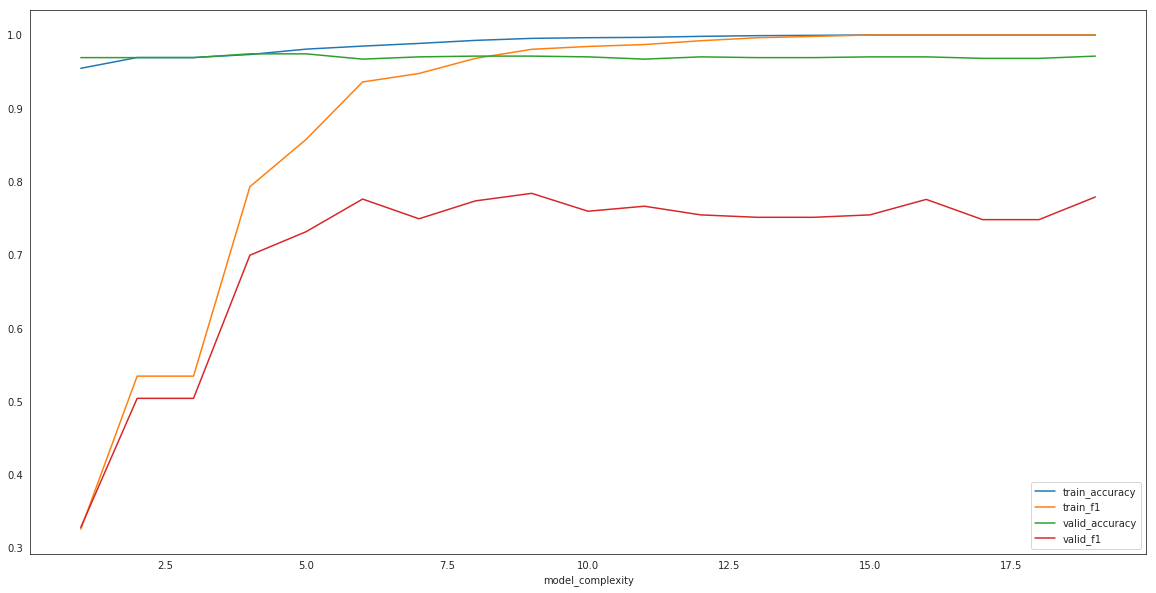

In [94]:
complexity_df.plot(x='model_complexity', figsize=(20, 10))

In [95]:
porovnanie_vysledkov

,Sposob,accuracy,precision,recall,f1 macro
0,Manualne pravidlo T4U,0.806584,0.428112,0.907516,0.462781
1,Manualne pravidlo T4U+TT4,0.862140,0.431107,0.900665,0.474772


In [96]:
from sklearn.model_selection import GridSearchCV
clf = DecisionTreeClassifier

cv_params = {'max_depth': [1,2,3,4] + list(range(5,10,2)), 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 3] }
ind_params = {'random_state': 0}
optimization = GridSearchCV(clf(**ind_params),
                            cv_params,
                            scoring='f1_macro', cv=5, n_jobs=-1, verbose=True)
X = zakodovane_trenovacie
y = zakodovane_trenovacie['class']
optimization.fit(X, y)
print(optimization.cv_results_)
print(optimization.best_estimator_)
print(optimization.best_score_)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: could not convert string to float: 'Megan Fraley'